# Importing/Storing data

In [1]:
#pip install wfdb 

In [44]:
%run "MIT-BIH Normal Sinus Rhythm DB.ipynb"

Amount to remove -11
Shape 0: 30113
Features for that specific segment:
Mean                160.400
STD                   8.830
RMSSD                 0.338
Normalized RMSSD      0.002
dtype: float64

features2 variable contains 30113 segments
float64
Length of y_list: 30113


In [45]:
import wfdb
import os
import glob
import pandas as pd
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sn

In [46]:
records = []
properties = []
annot = []
AnnSymb = []
AnnSamp = []
AnnRhythm = []
Rpeak_Samp = []
Rpeak_Symb = []


for f in glob.glob('C:/Users/masud/Skrivebord/Github_Bachelor_Project/wfdb-python/data/*.dat'): ##### change the path to own directory.       
                                                                                             ##### The rest should remin the same
                                                                                             ##### Useful function:
                                                                                             ##### print('Current directory is: {}'.format(os.getcwd()))
    sig, fields = wfdb.rdsamp(f[:-4], channels=[1])  #### In this function, pass 
                                                     #### "channels=[0]" or "channels=[1]" to select channel 1 or 2.
    ann = wfdb.rdann(f[:-4], 'atr')
    QRS = wfdb.rdann(f[:-4], 'qrs')
    Symb = pd.Series(ann.symbol)
    Samp = pd.Series(ann.sample)
    QRS_Symb = pd.Series(QRS.symbol)
    QRS_Samp = pd.Series(QRS.sample)
    Rhythm = pd.Series(ann.aux_note)
    records.append(sig)
    properties.append(fields)
    annot.append(ann)
    AnnSymb.append(Symb)
    AnnSamp.append(Samp)
    Rpeak_Symb.append(QRS_Symb)
    Rpeak_Samp.append(QRS_Samp)
    AnnRhythm.append(Rhythm)
    
    

AnnSymb = pd.Series(AnnSymb).values
AnnSamp = pd.Series(AnnSamp).values

# Checking the content of some variables (for the last record)

In [3]:
len(AnnSamp[22]) ### Contains 4 changes, these are outputted in following block

4

In [4]:
AnnRhythm[22] ### The 4 changes in the last record (eg. record 5 contains other arrythmias)

0       (N
1    (AFIB
2       (N
3    (AFIB
dtype: object

In [5]:
AnnSamp[22] ### So sample point 96 to 2808396 is '(N' --- and --- from 2808396 to 2820743 is '(AFIB'

0         96
1    2808396
2    2820743
3    2850351
dtype: int32

In [6]:
Rpeak_Samp[22] ### Output sample points that contains the R-peak of the last record

0            193
1            390
2            586
3            782
4            905
          ...   
59547    8999654
59548    8999811
59549    8999879
59550    8999948
59551    9000001
Length: 59552, dtype: int32

# Pre processing data...

In [47]:
x = 0
for i in range(23):
    x += np.sum(len(Rpeak_Samp[i]))
print(f"All Rpeaks amount: {x}")

All Rpeaks amount: 1128561


In [48]:
labeled_Rpeaks = []
appended_data = []
for i in range(23): ## 23 records
    for j in range(len(AnnSamp[i])-1): ## AnnSamp or AnnRhythm -- both same dimensions
        df = pd.DataFrame(Rpeak_Samp[i][(Rpeak_Samp[i] > AnnSamp[i][j]) & (Rpeak_Samp[i] < AnnSamp[i][j+1])])
        df['Label'] = AnnRhythm[i][j]
        appended_data.append(df)
        

labeled_Rpeaks = pd.concat(appended_data)

### Filter, only get Hearbeats with annotations '(N' OR '(AFIB'

In [49]:
labeled_Rpeaks_N_AFIB = labeled_Rpeaks.loc[(labeled_Rpeaks.Label == '(N') | (labeled_Rpeaks.Label == '(AFIB'), :]
labeled_Rpeaks_N_AFIB[0:1000] ### Visualising the first 1000 instances

,0,Label
0,61,(N
1,200,(N
2,358,(N
3,584,(N
4,729,(N
...,...,...
995,149897,(AFIB
996,149989,(AFIB
997,150086,(AFIB
998,150169,(AFIB


### Convert 'Label' column to boolean expr ----> '(AFIB' = 1 and '(N' = 0

In [50]:
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map( 
                   {'(N':False ,'(AFIB':True}) 

<ipython-input-50-10b1fee2832c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map(


In [51]:
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)

labeled_Rpeaks_N_AFIB.rename(columns={0: 'Rpeaks'},
          inplace=True, errors='raise')

<ipython-input-51-9cd7ad84a37a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [52]:
Rpeaks_N_AFIB = labeled_Rpeaks_N_AFIB["Rpeaks"]
Label_N_AFIB = labeled_Rpeaks_N_AFIB["Label"]
Label_N_AFIB = np.array(Label_N_AFIB, dtype=np.float64)

#labeled_Rpeaks_N_AFIB[0:1000]
labeled_Rpeaks_N_AFIB.isnull().values.any() ### Check for NaN values

False

# Segmenting & Feature Calculating 

### X - section

In [53]:
def segmenting_record(seg_value):
    rri2 = np.diff(Rpeaks_N_AFIB) ### Storing the intervals between rpeaks
    #print(rri2.dtype)
    rri2 = np.array(rri2, dtype=np.float64) ### So no overflow issues happens when calc in for loop later
    #print(rri2.dtype)
    #print(f"length before: {len(rri2)}")
    amount = -(len(rri2) % seg_value) #
    print(f"Amount to remove {amount}")
    rec_amount = rri2[:amount]
    #print(f"length before: {len(rec_amount)}")
    seg_shape = len(rec_amount) // seg_value #
    print(f"Shape 0: {seg_shape}")
    segmented_rec = rec_amount.reshape(seg_shape,seg_value) #
    return segmented_rec

### 1. Following function (above) is used, when different segment lengths is preffered (inputtet below)
### 2. Then read the outputs "Amount to remove" and "Shape 0" copy and paste this in the "Y - section".

In [54]:
segmented_record = segmenting_record(60)

Amount to remove -26
Shape 0: 11809


In [55]:
features2 = []

    ### Calculating features for every single segmented "block" inside the segmented_record variable
for x in range(len(segmented_record)):
    #MEAN
    ff1 = np.nanmean(segmented_record[x]) ### nanmean, nanstd computes values while ignoring nan-values
    #STD
    ff2 = np.nanstd(segmented_record[x])
    #RMSSD
    sum_ = 0
    for y in range(len(segmented_record[x]) - 1): ### loops 19 times
        sum_ += (segmented_record[x][y] - segmented_record[x][y+1])**2
    sum_multiplied = 1/(len(segmented_record) - 1) * sum_
    ff3 = np.sqrt(sum_multiplied)
    #NORMALIZED RMSSD
    ff4 = (ff3 / ff1)
    ### COVARIANCE
    #z = np.stack((ff1, ff2))
    #ff5 = np.cov(z) ### try cov with previous segment

    my_features2 = pd.Series([np.around(ff1,3), np.around(ff2,3), np.around(ff3,3), np.around(ff4,3)], 
                            index=['Mean','STD','RMSSD','Normalized RMSSD'])
    features2.append(my_features2)

In [56]:
n = 0

print(f"Features for that specific segment:\n{features2[n]}") 
print('\n'f"features2 variable contains {len(features2)} segments")

Features for that specific segment:
Mean                162.700
STD                  53.453
RMSSD                 4.102
Normalized RMSSD      0.025
dtype: float64

features2 variable contains 11809 segments


### Y - section 

### Paste the copied information below (indicated with the arrows)
1. Arrow: Add "Amount to remove" - 1, (remember the negative sign).
2. Arrow: Add "Shape 0" and then the segment size. (Shape 0 , segment size)
3. Arrow: Divide segment size by 2 and add here. (meaning if over half the segment contains "(AFIB" classify the whole segment as "(AFIB"

In [57]:
y_amount = Label_N_AFIB[:-27] # <=============== (1)
y_shape = y_amount.reshape(11809, 60) # <=============== (2)
y_list = []

### Calc if every 20 segment block is Normal synus rythm or AFIB
for l in range(len(y_shape)):
    #y_segment = y_shape
    sum_segment = np.sum(y_shape[l])
    if sum_segment >= 30: # <=============== (3)
        sum_segment = 1
    else: sum_segment = 0
    y_list.append(sum_segment)

y_list = np.array(y_list, dtype=np.float64)
print(y_list.dtype)
print(f"Length of y_list: {len(y_list)}")

float64
Length of y_list: 11809


### (below) Print shapes, to check if the segments allign for y and X

In [58]:
y = np.asarray(y_list)
print(f"shape of y: {np.shape(y)}, type of y: {type(y)}")
X = np.asarray(features2)
print(f"shape of X: {np.shape(X)}, type of X: {type(X)}")

shape of y: (11809,), type of y: <class 'numpy.ndarray'>
shape of X: (11809, 4), type of X: <class 'numpy.ndarray'>


In [59]:
df5 = pd.DataFrame(features2)
X = df5.values
df5

,Mean,STD,RMSSD,Normalized RMSSD
0,162.700,53.453,4.102,0.025
1,178.033,42.349,3.831,0.022
2,163.517,55.033,4.397,0.027
3,169.967,55.567,5.061,0.030
4,141.267,52.538,3.788,0.027
...,...,...,...,...
11804,186.983,13.098,1.610,0.009
11805,150.533,49.275,4.481,0.030
11806,145.933,50.787,4.117,0.028
11807,190.017,2.500,0.154,0.001


### (below) Print shapes, to check if the segments allign for y_nsr and X_nsr

In [60]:
y_nsr = np.asarray(y_list_nsr)
print(f"shape of y: {np.shape(y_nsr)}, type of y: {type(y_nsr)}")
X_nsr = np.asarray(features2_nsr)
print(f"shape of X: {np.shape(X_nsr)}, type of X: {type(X_nsr)}")

# df5_nsr = pd.DataFrame(features2_nsr)
# X_nsr = df5_nsr.values
# df5_nsr

shape of y: (30113,), type of y: <class 'numpy.ndarray'>
shape of X: (30113, 4), type of X: <class 'numpy.ndarray'>


# Classifications algorithms
### (This code used when the ML models are not implemented in the Pipelines)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#### SVM

In [23]:
# model = SVC()
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# clf = GridSearchCV(model, parameters)
# clf.fit(X_train, y_train)

# df_svm_results = pd.DataFrame(clf.cv_results_)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# scaler = StandardScaler()
# scaler.fit(X)
# scaler.transform(X)

#### Decision trees

In [24]:
# clf = tree.DecisionTreeClassifier()
# clf.fit(X_train, y_train)
#clf.score(X_test, y_test) 

#### Random forest

In [25]:
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
# rf_y_predicted = clf.predict(X_test)
# cm = confusion_matrix(y_test, rf_y_predicted)
# %matplotlib inline
# plt.figure(figsize=(6,4))
# sn.heatmap(cm,annot=True)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

# Pipelines

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [63]:
##### Choosen params after runned GridsearchCV 

pipeline_svm = Pipeline([('scalar1', StandardScaler()),
                         ('svm_classifier', SVC(gamma="scale", C=20, kernel='rbf', probability=True))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('dt_classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=12))])

# pipeline_nb = Pipeline([('scalar3', StandardScaler()),
#                        ('nb_classifier', GaussianNB())]) ### No gridsearch, because no hyperparameters

pipeline_rf = Pipeline([('scalar 4', StandardScaler()),
                         ('rf_classifier', RandomForestClassifier(n_estimators=200))])


# Train Test Split (80/20)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [65]:
X_train_nsr, X_test_nsr, y_train_nsr, y_test_nsr = train_test_split(X_nsr, y_nsr, test_size=0.2)

# Ensemble classifiers

In [66]:
#pip install xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

#### StackingClassifier

In [67]:
estimators = [('svm',pipeline_svm), ('dt',pipeline_dt), ('rf',pipeline_rf)]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())


#### xgboost

In [68]:
xgb_model = XGBClassifier()

#### AdaBoost

In [69]:
adaBoost_clf = AdaBoostClassifier()

# Cross validation

In [70]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold ### For class inbalances through out the data

In [71]:
#%%time #53min
cv_svm_results = cross_validate(pipeline_svm, X, y, cv=5,
                        return_estimator=False, return_train_score=True) ### set return_estimator=True to return the fitted estimator

#scoring = ['precision_macro']

In [72]:
#%%time #1min
cv_dt_results = cross_validate(pipeline_dt, X, y, cv=5,
                        return_estimator=False, return_train_score=True)
# cv_nb_results = cross_validate(pipeline_nb, X, y, cv=5,
#                         return_estimator=False)
cv_rf_results = cross_validate(pipeline_rf, X, y, cv=5,
                        return_estimator=False, return_train_score=True)

In [73]:
##takes half hour to run
cv_stacking_results = cross_validate(clf, X, y, cv=5,
                        return_estimator=False, return_train_score=True)
cv_xgb_results = cross_validate(xgb_model, X, y, cv=5,
                        return_estimator=False, return_train_score=True)
cv_ab_results = cross_validate(adaBoost_clf, X, y, cv=5,
                        return_estimator=False, return_train_score=True)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Probability calculations for ROC and AUC metrics

###### (Do below code block only 1's, do it before outputting nsr results)

In [3]:
probs_svm = pipeline_svm.predict_proba(X_test)
probs_dt = pipeline_dt.predict_proba(X_test)
# probs_nb = pipeline_nb.predict_proba(X_test)
probs_rf = pipeline_rf.predict_proba(X_test)

probs_stacking = pipeline_rf.predict_proba(X_test)
probs_xgb = pipeline_rf.predict_proba(X_test)
probs_ab = pipeline_rf.predict_proba(X_test)

# probs_voting_soft = eclf2.predict_proba(X_test)


### Probabilities for the positive outcome is kept
probs_svm = probs_svm[:,1]
probs_dt = probs_dt[:,1]
# probs_nb = probs_nb[:,1]
probs_rf = probs_rf[:,1]

probs_stacking = probs_stacking[:,1]
probs_xgb = probs_xgb[:,1]
probs_ab = probs_ab[:,1]

#probs_voting_soft = probs_voting_soft[:,1]

In [4]:
auc_svm = metrics.roc_auc_score(y_test, probs_svm)
auc_dt = metrics.roc_auc_score(y_test, probs_dt)
# auc_nb = metrics.roc_auc_score(y_test, probs_nb)
auc_rf = metrics.roc_auc_score(y_test, probs_rf)

auc_stacking = metrics.roc_auc_score(y_test, probs_stacking)
auc_xgb = metrics.roc_auc_score(y_test, probs_xgb)
auc_ab = metrics.roc_auc_score(y_test, probs_ab)

#auc_voting_soft = metrics.roc_auc_score(y_test, probs_voting_soft)

In [5]:
fpr_swm, tpr_swm, thresholds_swm = metrics.roc_curve(y_test, probs_svm)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, probs_dt)
# fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(y_test, probs_nb)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, probs_rf)

fpr_stacking, tpr_stacking, thresholds_stacking = metrics.roc_curve(y_test, probs_stacking)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test, probs_xgb)
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(y_test, probs_ab)

#fpr_voting, tpr_voting, thresholds_voting = metrics.roc_curve(y_test, probs_voting_soft)

# Results

In [74]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.datasets import make_classification

### scores

In [75]:
print(f"SVM Scores: {cv_svm_results['test_score']}")
print(f"Mean: {np.mean(cv_svm_results['test_score'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['test_score']}")
print(f"Mean: {np.mean(cv_dt_results['test_score'])}")
print()
# print(f"Naive bayes Scores: {cv_nb_results['test_score']}")
# print(f"Mean: {np.mean(cv_nb_results['test_score'])}")
# print()
print(f"Random forest: {cv_rf_results['test_score']}")
print(f"Mean: {np.mean(cv_rf_results['test_score'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['test_score']}")
print(f"Mean: {np.mean(cv_stacking_results['test_score'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['test_score']}")
print(f"Mean: {np.mean(cv_xgb_results['test_score'])}")
print()
print(f"AdaBoost Scores: {cv_ab_results['test_score']}")
print(f"Mean: {np.mean(cv_ab_results['test_score'])}")
print("-------------------------------(Testing scores above)------------------------------------------------------")
print("-----------------------------------------------------------------------------------------------------------")
print("-------------------------------(Training scores below)-----------------------------------------------------")
print(f"SVM Scores: {cv_svm_results['train_score']}")
print(f"Mean: {np.mean(cv_svm_results['train_score'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['train_score']}")
print(f"Mean: {np.mean(cv_dt_results['train_score'])}")
print()
# print(f"Naive bayes Scores: {cv_nb_results['test_score']}")
# print(f"Mean: {np.mean(cv_nb_results['test_score'])}")
# print()
print(f"Random forest: {cv_rf_results['train_score']}")
print(f"Mean: {np.mean(cv_rf_results['train_score'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['train_score']}")
print(f"Mean: {np.mean(cv_stacking_results['train_score'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['train_score']}")
print(f"Mean: {np.mean(cv_xgb_results['train_score'])}")
print()
print(f"AdaBoost Scores: {cv_ab_results['train_score']}")
print(f"Mean: {np.mean(cv_ab_results['train_score'])}")

SVM Scores: [0.9364945  0.89881456 0.87171888 0.90431837 0.80304956]
Mean: 0.8828791743907937

Decision tree Scores: [0.91744285 0.92040644 0.90347163 0.92675699 0.81956798]
Mean: 0.8975291759508611

Random forest: [0.92845047 0.92972058 0.91532599 0.9491956  0.84371029]
Mean: 0.9132805851221211

Stacking classifier Scores: [0.94157494 0.93268417 0.91363251 0.95893311 0.83566285]
Mean: 0.9164975159064118

xgboost Scores: [0.92929721 0.92675699 0.9195597  0.95300593 0.84498094]
Mean: 0.9147201507993463

AdaBoost Scores: [0.93141406 0.92421677 0.8954276  0.93903472 0.81745023]
Mean: 0.9015086748715454
-------------------------------(Testing scores above)------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-------------------------------(Training scores below)-----------------------------------------------------
SVM Scores: [0.87985604 0.8858897  0.89224092 0.87435165 0.91342083]


### Evaluate on MIT-BIH Normal Sinus Rhythm Database

In [76]:
pipeline_svm.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)
# pipeline_nb.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

clf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
adaBoost_clf.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

In [77]:
print(f"SVM: {pipeline_svm.score(X_test_nsr, y_test_nsr)}")
print(f"DT: {pipeline_dt.score(X_test_nsr, y_test_nsr)}")
# print(f"NB: {pipeline_nb.score(X_test_nsr, y_test_nsr)}")
print(f"RF: {pipeline_rf.score(X_test_nsr, y_test_nsr)}")
print()
print(f"Stacking: {clf.score(X_test_nsr, y_test_nsr)}")
print(f"Xgbost: {xgb_model.score(X_test_nsr, y_test_nsr)}")
print(f"AdaBoost: {adaBoost_clf.score(X_test_nsr, y_test_nsr)}")
print("------------------------------------(Testing scores above)----------------------------------------------------")
print("--------------------------------------------------------------------------------------------------------------")
print("------------------------------------(Training scores below)---------------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_train_nsr, y_train_nsr)}")
print(f"DT: {pipeline_dt.score(X_train_nsr, y_train_nsr)}")
# print(f"NB: {pipeline_nb.score(X_train_nsr, y_train_nsr)}")
print(f"RF: {pipeline_rf.score(X_train_nsr, y_train_nsr)}")
print()
print(f"Stacking: {clf.score(X_train_nsr, y_train_nsr)}")
print(f"Xgbost: {xgb_model.score(X_train_nsr, y_train_nsr)}")
print(f"AdaBoost: {adaBoost_clf.score(X_train_nsr, y_train_nsr)}")

SVM: 0.9277768553876805
DT: 0.9317615806076706
RF: 0.9287730366926781

Stacking: 0.9389008799601527
Xgbost: 0.9281089158226797
AdaBoost: 0.8962311140627595
------------------------------------(Testing scores above)----------------------------------------------------
--------------------------------------------------------------------------------------------------------------
------------------------------------(Training scores below)---------------------------------------------------
SVM: 0.9298464092984641
DT: 0.9325861353258613
RF: 0.9336239103362391

Stacking: 0.942258198422582
Xgbost: 0.9320464923204649
AdaBoost: 0.8963055209630552


### Clasification report (SVM example)

In [91]:
# y_pred_test = pipeline_svm.predict(X_test)
# # print(classification_report(y_pred_test, y_test))

# ### (above) the parameters was inputted in wrong positions, corrected with below lines.
# target_names = ['class 0', 'class 1']
# print(classification_report(y_test, y_pred_test, target_names=target_names))

# Confusion Matrix

In [51]:
y_pred_svm = pipeline_svm.predict(X_test)
y_pred_dt = pipeline_dt.predict(X_test)
# y_pred_nb = pipeline_nb.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_stacking = clf.predict(X_test)
y_pred_xgboost = xgb_model.predict(X_test)
y_pred_adaboost = adaBoost_clf.predict(X_test)


cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_dt = confusion_matrix(y_test, y_pred_dt)
# cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
cm_xgboost = confusion_matrix(y_test, y_pred_xgboost)
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)
target_names = ['Normal', 'AFIB']

##### confusion matrices for nsr data (trained on afib data)

In [78]:
y_pred_svm_nsr = pipeline_svm.predict(X_test_nsr)
y_pred_dt_nsr = pipeline_dt.predict(X_test_nsr)
# y_pred_nb = pipeline_nb.predict(X_test)
y_pred_rf_nsr = pipeline_rf.predict(X_test_nsr)
y_pred_stacking_nsr = clf.predict(X_test_nsr)
y_pred_xgboost_nsr = xgb_model.predict(X_test_nsr)
y_pred_adaboost_nsr = adaBoost_clf.predict(X_test_nsr)


cm_svm_nsr = confusion_matrix(y_test_nsr, y_pred_svm_nsr)
cm_dt_nsr = confusion_matrix(y_test_nsr, y_pred_dt_nsr)
# cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_rf_nsr = confusion_matrix(y_test_nsr, y_pred_rf_nsr)
cm_stacking_nsr = confusion_matrix(y_test_nsr, y_pred_stacking_nsr)
cm_xgboost_nsr = confusion_matrix(y_test_nsr, y_pred_xgboost_nsr)
cm_adaboost_nsr = confusion_matrix(y_test_nsr, y_pred_adaboost_nsr)
target_names_nsr = ['Normal', 'AFIB']

In [79]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=15)
        plt.yticks(tick_marks, target_names, fontsize=15)

    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     fontsize=20, #####
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass), fontsize=20)
    plt.show()

### CM SVM

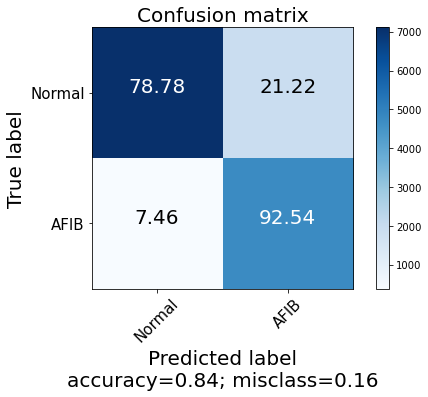

In [54]:
## Number better in percentage
plot_confusion_matrix(cm=cm_svm, target_names=target_names)

### CM DT

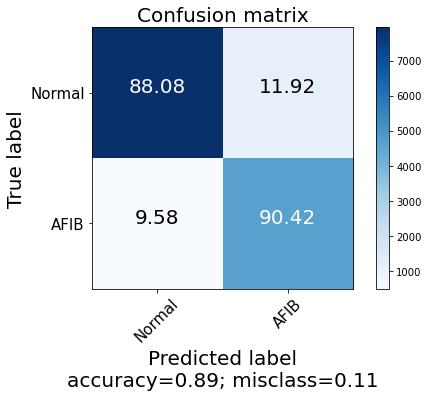

In [55]:
plot_confusion_matrix(cm=cm_dt, target_names=target_names)

### CM RandomForest

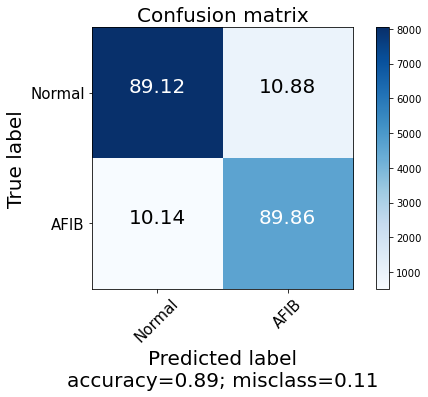

In [56]:
plot_confusion_matrix(cm=cm_rf, target_names=target_names)

### CM Stacking

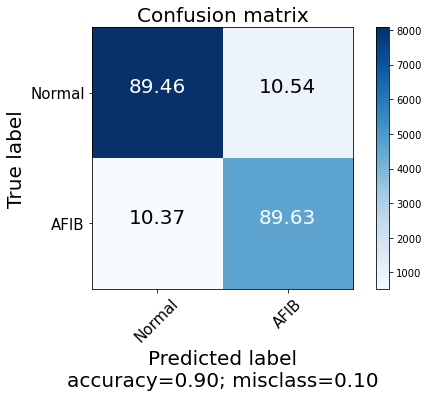

In [57]:
plot_confusion_matrix(cm=cm_stacking, target_names=target_names)

### CM XGBoost

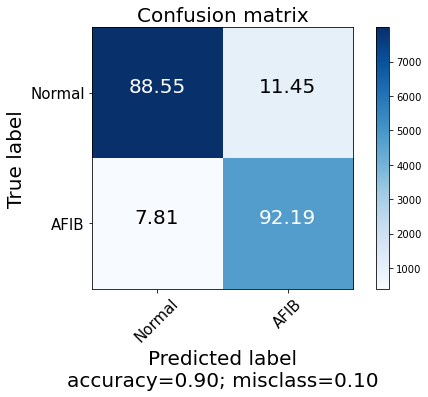

In [58]:
plot_confusion_matrix(cm=cm_xgboost, target_names=target_names)

### CM AdaBoost

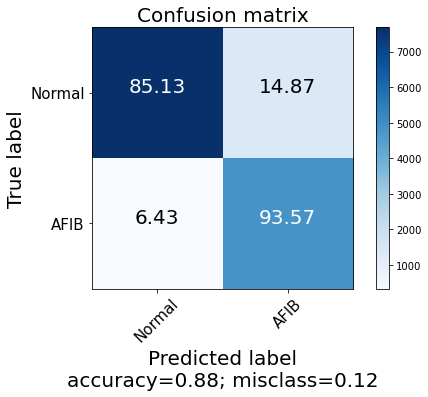

In [59]:
plot_confusion_matrix(cm=cm_adaboost, target_names=target_names)

##### CM_SVM_NSR
##### CM_DT_NSR
##### CM_RF_NSR
##### CM_STACKING_NSR
##### CM_XGBOOST_NSR
##### CM_ADABOOST_NSR

<ipython-input-79-798e79fb63c2>:58: RuntimeWarning: invalid value encountered in true_divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


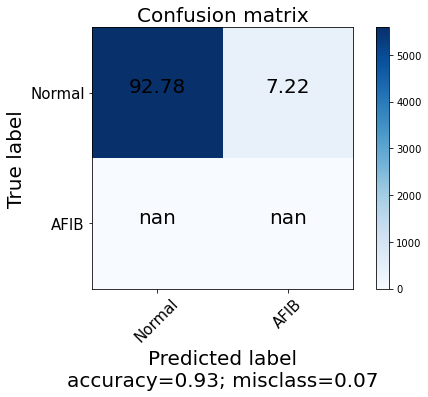

In [80]:
plot_confusion_matrix(cm=cm_svm_nsr, target_names=target_names_nsr)

<ipython-input-79-798e79fb63c2>:58: RuntimeWarning: invalid value encountered in true_divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


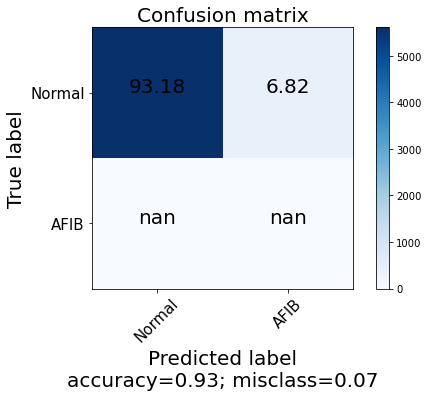

In [81]:
plot_confusion_matrix(cm=cm_dt_nsr, target_names=target_names_nsr)

<ipython-input-79-798e79fb63c2>:58: RuntimeWarning: invalid value encountered in true_divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


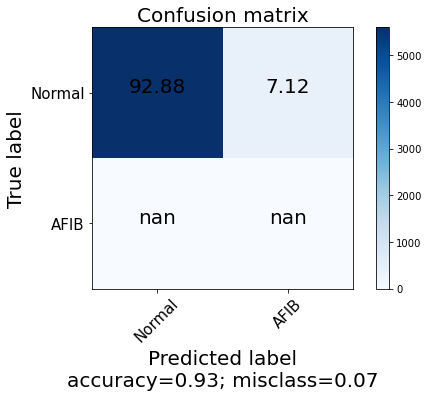

In [82]:
plot_confusion_matrix(cm=cm_rf_nsr, target_names=target_names_nsr)

<ipython-input-79-798e79fb63c2>:58: RuntimeWarning: invalid value encountered in true_divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


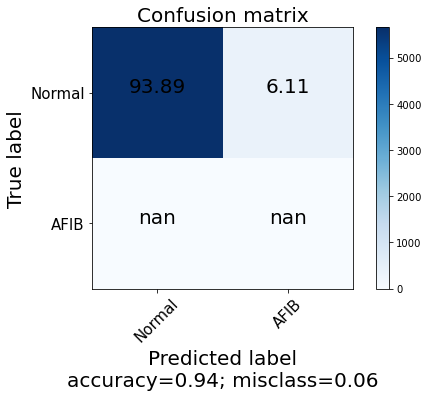

In [83]:
plot_confusion_matrix(cm=cm_stacking_nsr, target_names=target_names_nsr)

<ipython-input-79-798e79fb63c2>:58: RuntimeWarning: invalid value encountered in true_divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


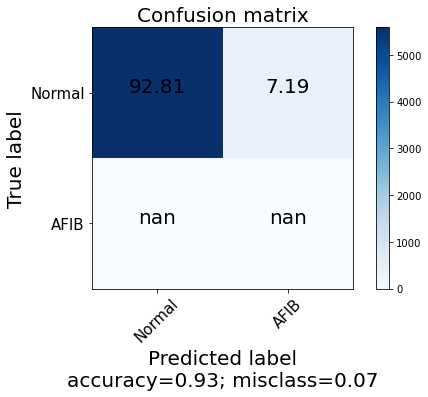

In [84]:
plot_confusion_matrix(cm=cm_xgboost_nsr, target_names=target_names_nsr)

<ipython-input-79-798e79fb63c2>:58: RuntimeWarning: invalid value encountered in true_divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


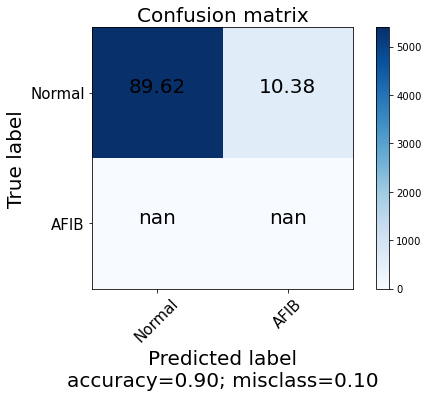

In [85]:
plot_confusion_matrix(cm=cm_adaboost_nsr, target_names=target_names_nsr)

### ROC curve

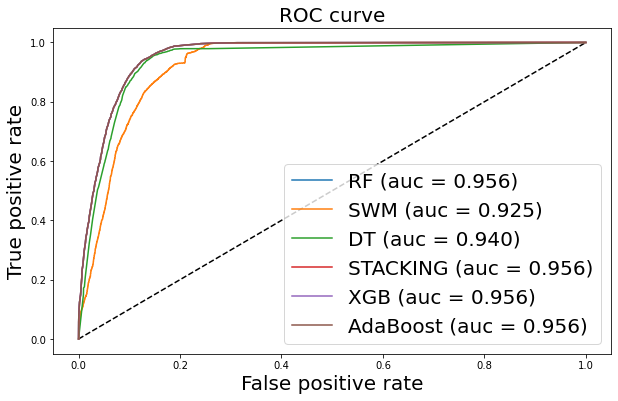

In [53]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
# plt.plot(fpr_voting, tpr_voting, label='Voting Clf (auc = %0.3f)' % auc_voting_soft)

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

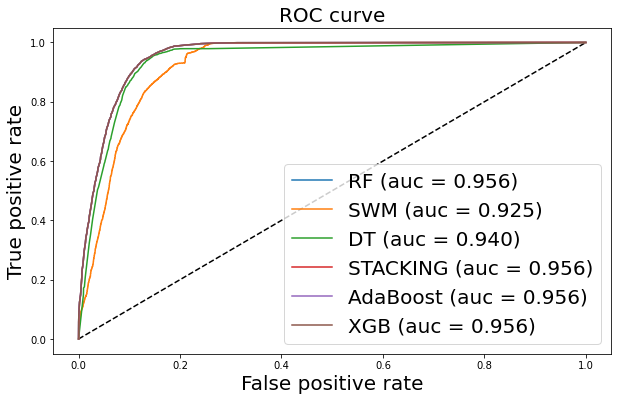

In [54]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
# plt.plot(fpr_voting, tpr_voting, label='Voting Clf (auc = %0.3f)' % auc_voting_soft)

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

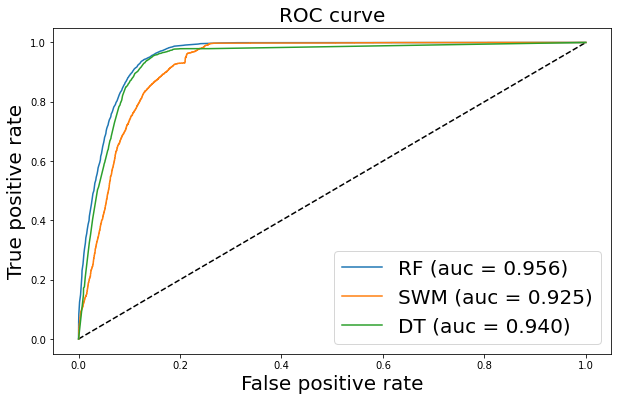

In [55]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
# plt.plot(fpr_voting, tpr_voting, label='NB (auc = %0.3f)' % auc_voting_soft)

# plt.plot(fpr_stacking, tpr_stacking, marker='o', label='STACKING (auc = %0.3f)' % auc_stacking)
# plt.plot(fpr_xgb, tpr_xgb, marker='^', label='XGB (auc = %0.3f)' % auc_xgb)
# plt.plot(fpr_ab, tpr_ab, marker='s', label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

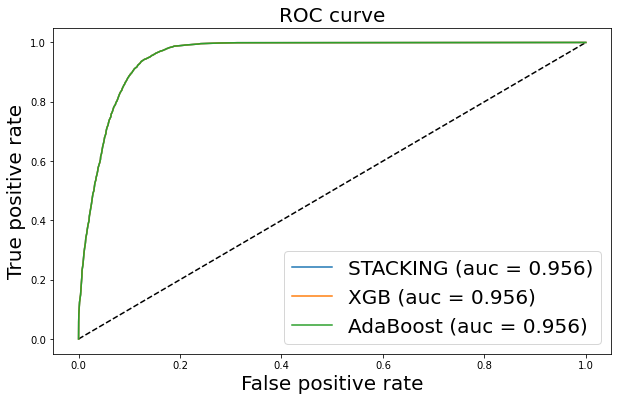

In [56]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
# plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
# plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
# plt.plot(fpr_voting, tpr_voting, label='NB (auc = %0.3f)' % auc_voting_soft)

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

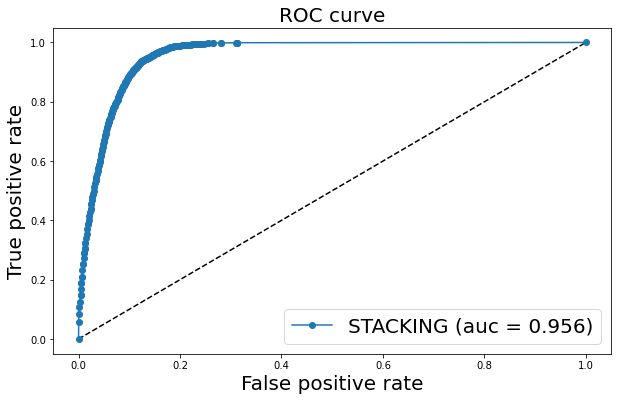

In [57]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
# plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
# plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
# plt.plot(fpr_voting, tpr_voting, label='NB (auc = %0.3f)' % auc_voting_soft)

plt.plot(fpr_stacking, tpr_stacking, marker='o', label='STACKING (auc = %0.3f)' % auc_stacking)
# plt.plot(fpr_xgb, tpr_xgb, marker='^', label='XGB (auc = %0.3f)' % auc_xgb)
# plt.plot(fpr_ab, tpr_ab, marker='s', label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

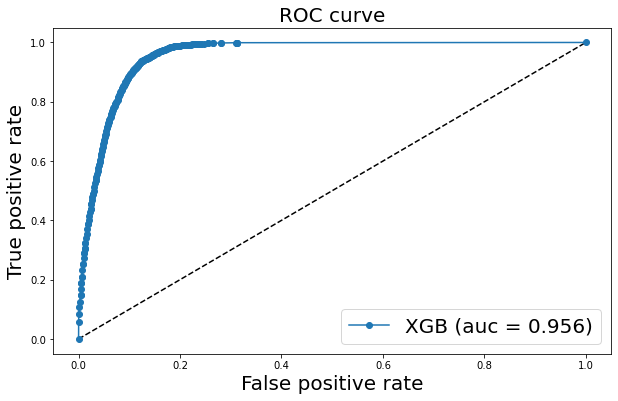

In [58]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
# plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
# plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
# plt.plot(fpr_voting, tpr_voting, label='NB (auc = %0.3f)' % auc_voting_soft)

# plt.plot(fpr_stacking, tpr_stacking, marker='o', label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, marker='o', label='XGB (auc = %0.3f)' % auc_xgb)
# plt.plot(fpr_ab, tpr_ab, marker='s', label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

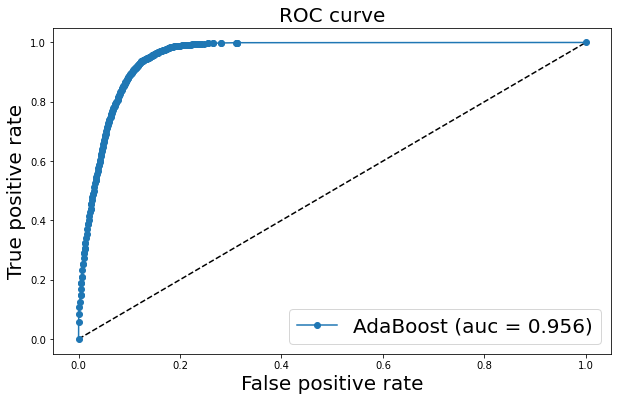

In [59]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
# plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
# plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
# plt.plot(fpr_voting, tpr_voting, label='NB (auc = %0.3f)' % auc_voting_soft)

# plt.plot(fpr_stacking, tpr_stacking, marker='o', label='STACKING (auc = %0.3f)' % auc_stacking)
# plt.plot(fpr_xgb, tpr_xgb, marker='^', label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, marker='o', label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

# Table overview: scoring = ['test_score']

### Segment amount 10
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.92075924 0.84080164 0.84313034 0.79733258 0.78378378] | 0.8371615163468551 |
| Decision tree | [0.92075924 0.89704326 0.86662903 0.85794933 0.79225178] | 0.8669265294016855 |
| Random forest | [0.92111205 0.89450286 0.87396796 0.86535883 0.79514501] | 0.8700173437011935 |
| Stacking classifier | [0.92725092 0.89450286 0.8736857  0.8781314  0.79140498] | 0.8729951696998475 |
|<b> <font color='blue'>xgboost</font> </b> | [0.92823878 0.90275916 0.87989556 0.86931056 0.79810881] | <b>0.875662575135407</b> |  
| adaBoost | [0.93600056 0.91101545 0.8639475 0.86662903 0.78300755] | 0.8721200197506953 |
| Voting Classifier (HARD) | No cross validation | 0.7318656505786058 |
| Voting Classifier (SOFT) | No cross validation | 0.73652272085803 |

### Segment amount 15
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.93056732 0.86515665 0.84767651 0.81475601 0.77379062] | 0.8463894204728962 |
| Decision tree | [0.91712532 0.89997883 0.88557214 0.8959458  0.80067746] | 0.8798599109950456 |
| Random forest | [0.91680779 0.89648603 0.88673653 0.89806288 0.806076  ] | 0.8808338457961511 |
| Stacking classifier | [0.92876799 0.90008467 0.88663068 0.91923362 0.80205356] | 0.8873541049504132 |
| <b> <font color='blue'>xgboost</font> </b> | [0.92749788 0.90643522 0.89266434 0.90462581 0.80872235] | <b>0.8879891196547574</b> |
| adaBoost | [0.93681202 0.91151566 0.87339896 0.88800677 0.79919551] | 0.8817857874946883 |
| Voting Classifier (HARD) | No cross validation | 0.8512559977420265 | 
| Voting Classifier (SOFT) | No cross validation | 0.857324301439458 |

### Segment amount 20
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.9322608  0.87552921 0.86014677 0.86704305 0.76979534] | 0.8609550335419408 |
| Decision tree | [0.92012419 0.9062941  0.88399661 0.89188426 0.79971771] | 0.8804033757261079 |
| Random forest | [0.91913633 0.89627434 0.89867344 0.92025406 0.81425547] | 0.8897187273363582 |
| Stacking classifier | [0.93000282 0.90093141 0.893593 0.92971066 0.8052223] | 0.8918920387512547 |
| xgboost | [0.92238216 0.90220152 0.90333051 0.91743119 0.81580805] | 0.8922306869669157 |
| adaBoost | [0.93353091 0.89895569 0.88583122 0.8962597  0.78645025] | 0.8802055520731189 |
| Voting Classifier (HARD) | No cross validation | 0.9486311035845328 | 
| <b> <font color='blue'>Voting Classifier (SOFT)</font> </b> | No cross validation | <b>0.9508890770533446</b> |

### Segment amount 25
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.93684953 0.88322455 0.87155963 0.87579393 0.77875794] | 0.8692371180632625 |
| Decision tree | [0.90915505 0.90156994 0.8895554  0.9089626  0.81263232] | 0.8843750626324776 |
| Random forest | [0.91920974 0.90174634 0.90561044 0.92589979 0.81986591]| 0.8944664447396997 |
| Stacking classifier | [0.9310284  0.90421591 0.90137615 0.93772054 0.81351447] | 0.8975710922967126 |
| <b> <font color='blue'>xgboost</font> </b> | [0.92432528 0.90245193 0.91037403 0.92978123 0.82127735] | <b>0.8976419626955051</b>|
| adaBoost | [0.93543835 0.91585818 0.88143966 0.92043049 0.79569513]] | 0.8897723607436501 |
| Voting Classifier (HARD) | No cross validation | 0.8755292125317528 | 
| Voting Classifier (SOFT) | No cross validation | 0.8760937058989556 |

### Segment amount 60
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.9364945  0.89881456 0.87171888 0.90431837 0.80304956]| 0.8828791743907937 |
| Decision tree | [0.91871296 0.92082981 0.9081287  0.92972058 0.82126218] | 0.8997308435374297 |
| Random forest | [0.93183743 0.9322608  0.91447925 0.95004234 0.84709869] |  0.915143700142844 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.93776461 0.93141406 0.91320914 0.96062659 0.83566285] | <b>0.9157354498606878</b> |
| xgboost | [0.92929721 0.92675699 0.9195597  0.95300593 0.84498094] | 0.9147201507993463 |
| adaBoost | [0.93141406 0.92421677 0.8954276  0.93903472 0.81745023] | 0.9015086748715454 |
| Voting Classifier (HARD) | No cross validation | 0.6841659610499576 |
| Voting Classifier (SOFT) | No cross validation | 0.6881174146203782 |

### Segment amount 120
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.93480102 0.91363251 0.86198137 0.94157494 0.79830508]| 0.8900589847730307 |
| Decision tree | [0.90770533 0.92548688 0.88484335 0.94834886 0.82966102] | 0.8992090873864435 |
| Random forest | [0.9237934  0.9407282  0.90685859 0.96104996 0.82457627] | 0.9114012830264497 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.93734124 0.9407282  0.89585097 0.96951736 0.81694915] | <b>0.9120773834297277</b> |
| xgboost | [0.90855207 0.92887384 0.90347163 0.957663   0.83220339] | 0.9061527863488281 |
| adaBoost | [0.93734124 0.9364945  0.88653683 0.95004234 0.81694915] | 0.9054728110334533 |
| Voting Classifier (HARD) | No cross validation | 0.6699125035280835 |
| Voting Classifier (SOFT) | No cross validation | 0.6783799040361276 |

# Table overview: scoring = ['precision_macro']

### Segment amount 10

| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.90901609 0.82913128 0.83751363 0.79804735 0.79050442] | 0.8328425557402422 |
| Decision tree | [0.9091379  0.883873   0.85304185 0.8529422  0.78019421] | 0.8558378305694516 |
| Random forest | [0.91035706 0.88853696 0.85955471 0.85584218 0.78217434] | 0.859293050533927 |
| Stacking classifier | [0.91633424 0.88794029 0.85991648 0.86799686 0.77727863] | 0.8618933018364766 |
|<b> <font color='blue'>xgboost</font> </b> | [0.91781089 0.89484278 0.86629533 0.86209761 0.78692103] | <b>0.8655935272677568</b> |  
| adaBoost | [0.92504207 0.90307636 0.85256869 0.86064788 0.77918339] | 0.8641036786319866 |

### Segment amount 20
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.92118499 0.86178046 0.84719857 0.85588685 0.77298434] | 0.8518070430052868 |
| Decision tree | [0.90463721 0.89701568 0.87030209 0.88093824 0.78244283] | 0.8670672086146567 |
| Random forest | [0.90885777 0.89006886 0.88653765 0.90861018 0.80115661] | 0.8790462133976753 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.91872233 0.89636211 0.88322156 0.91809779 0.78941333] | <b>0.8811634252907714</b>|
| xgboost | [0.91116523 0.89531492 0.89047711 0.90500501 0.80120198] | 0.8806328505197618 |
| adaBoost | [0.92199619 0.89281512 0.87258715 0.88516904 0.77376375] | 0.8806328505197618 |

### Segment amount 60
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.92501342 0.88580256 0.86103527 0.89190853 0.80146878]| 0.8730457106959557 |
| Decision tree | [0.91315572 0.91338482 0.89238663 0.91800241 0.80481384] | 0.8883486859473735 |
| Random forest | [0.91854214 0.92321429 0.90506758 0.93944582 0.83117845] |  0.9034896542288781 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.93226222 0.92338524 0.90520768 0.95202 0.82510008] | <b>0.9075950454507294</b> |
| xgboost | [0.91850551 0.91925385 0.90759045 0.94505354 0.83007033] | 0.9040947345160714 |
| adaBoost | [0.92001345 0.91576532 0.88294673 0.92885481 0.80175305] | 0.8898666720527755 |

### Segment amount 120
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.92325695 0.90212192 0.85257555 0.93080192 0.7934675]| 0.880444768805296 |
| Decision tree | [0.89160153 0.91648605 0.872511   0.94446946 0.81329853] | 0.8876733146580251 |
| <b> <font color='blue'>Random forest</font> </b> | [0.91749582 0.93126885 0.89715865 0.96097628 0.8130069] |  <b>0.9039812993810619</b> |
| Stacking classifier | [0.9283578  0.93419934 0.88484117 0.96806379 0.80084259] | 0.903260937296853 |
| xgboost | [0.89934208 0.92393306 0.89098086 0.95323892 0.81823833] | 0.8971466500331117 |
| adaBoost | [0.92644658 0.92807614 0.87398324 0.943755 0.80205616] | 0.894863424594331 |

# VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[
        ('svm', pipeline_svm), ('dt', pipeline_dt), ('rf', pipeline_rf), 
        ('stacking', clf), ('xgb', xgb_model), ('AdaBoost', adaBoost_clf)], 
        voting='hard', verbose=1)
eclf1 = eclf1.fit(X, y)


eclf2 = VotingClassifier(estimators=[
        ('svm', pipeline_svm), ('dt', pipeline_dt), ('rf', pipeline_rf), 
        ('stacking', clf), ('xgb', xgb_model), ('AdaBoost', adaBoost_clf)],
        voting='soft', verbose=1)
eclf2 = eclf2.fit(X, y)

In [ ]:
print("---------TESTING----------")
print(eclf1.score(X_test, y_test))
print(eclf2.score(X_test, y_test))
print("---------TRAINING----------")
print(eclf1.score(X_train, y_train))
print(eclf2.score(X_train, y_train))

### CM Voting Classifier (Hard & Soft)

In [ ]:
### HARD
y_pred_voting_clf_hard = eclf1.predict(X_test)
cm_voting_clf_hard = confusion_matrix(y_test, y_pred_voting_clf_hard)
### SOFT
y_pred_voting_clf_soft = eclf2.predict(X_test)
cm_voting_clf_soft = confusion_matrix(y_test, y_pred_voting_clf_soft)

In [ ]:
plot_confusion_matrix(cm=cm_voting_clf_soft, target_names=target_names)

In [ ]:
plot_confusion_matrix(cm=cm_voting_clf_hard, target_names=target_names)

In [ ]:
probs_voting_soft = eclf2.predict_proba(X_test)
probs_voting_soft = probs_voting_soft[:,1]
auc_voting_soft = metrics.roc_auc_score(y_test, probs_voting_soft)
fpr_voting, tpr_voting, thresholds_voting = metrics.roc_curve(y_test, probs_voting_soft)

### Other

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = pipeline_svm
clf2 = pipeline_dt
clf3 = pipeline_rf
X = np.array([[-1.0, -1.0], [-1.2, -1.4], [-3.4, -2.2], [1.1, 1.2]])
y = np.array([1, 1, 2, 2])

eclf = VotingClassifier(estimators=[('svm', pipeline_svm), ('dt', pipeline_dt), ('rf', pipeline_rf)],
                        voting='soft')

# predict class probabilities for all classifiers
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['SVM\nweight 1',
                    'DecisionTree\nweight 1',
                    'RandomForestClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.show()

### Permutation importance

In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.inspection import permutation_importance

# X, y = make_classification(random_state=0, n_features=5, n_informative=3)
# feature_names = np.array([f'x_{i}' for i in range(X.shape[1])])

# rf = RandomForestClassifier(random_state=0).fit(X, y)
# result = permutation_importance(rf, X, y, n_repeats=10, random_state=0,
#                                 n_jobs=-1)

# fig, ax = plt.subplots()
# sorted_idx = result.importances_mean.argsort()
# ax.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=feature_names[sorted_idx])
# ax.set_title("Permutation Importance of each feature")
# ax.set_ylabel("Features")
# fig.tight_layout()
# plt.show()

# GridsearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
pipeline_svm.get_params().keys()

In [ ]:
# from time import time
# t0 = time()
# parameters = {'svm_classifier__C':[1, 10, 20], 'svm_classifier__kernel':['linear', 'rbf']}
# #parameters = {'rf_classifier__n_estimators': [200, 700], 'rf_classifier__max_features': ['auto', 'sqrt', 'log2'], 'rf_classifier__criterion':['gini','entropy']}
# clf = GridSearchCV(pipeline_swm, parameters, cv=5)
# clf.fit(X_train, y_train)
# print("done in %0.3fs" % (time() - t0))

In [ ]:
#df_search_results = pd.DataFrame(clf.cv_results_)
#df_search_results

In [ ]:
#df_search_results[['param_rf_classifier__criterion', 'param_rf_classifier__max_depth', 'mean_test_score']]
#clf.best_params_